<a href="https://colab.research.google.com/github/maede43/ensemble-learning-lfw/blob/main/Ensemble_learning_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='orange'><center>**Final Project Of Computational Intelligence**</center></font>
### <font color='lightgreen'><center>Maedeh Nadehi</center></font>

## <font color='orange'>Ensemble learning</font>
***Ensemble learning*** is a general meta approach to machine learning that seeks better predictive performance by combining the predictions from multiple models.
<br>
The three main classes of ensemble learning methods are :

>  *bagging* <br>
>  *stacking* <br>
>  *boosting* <br>

## <font color='orange'>Bagging Ensemble Learning</font>
Bootstrap aggregation, or bagging for short, is an ensemble learning method that seeks a diverse group of ensemble members by varying the training data.
<br>
This typically involves using a single machine learning algorithm, almost always an unpruned decision tree, and training each model on a different sample of the same training dataset. The predictions made by the ensemble members are then combined using simple statistics, such as ***voting*** or ***averaging***.
<br>

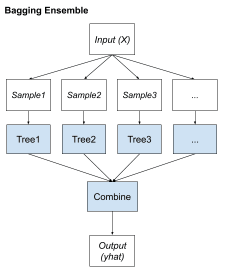
<br>
Many popular ensemble algorithms are based on this approach, including:

> Bagged Decision Trees (canonical bagging) <br>
> [Random Forest](#cell-1) <font color='lightgreen' size="1"> Which has been used</font> <br>
> Extra Trees <br>

## <font color='orange'>Stacking Ensemble Learning</font>
Stacked Generalization, or stacking for short, is an ensemble method that seeks a diverse group of members by varying the model types fit on the training data and using a model to combine predictions.
<br>

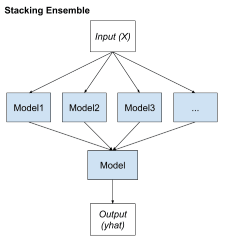
<br>
Many popular ensemble algorithms are based on this approach, including:

> [Stacked Models](#cell-2)<font color='lightgreen' size="1"> Which has been used</font> <br>
> Blending <br>
> Super Ensemble <br>

## <font color='orange'>Boosting Ensemble Learning</font>
Boosting is an ensemble method that seeks to change the training data to focus attention on examples that previous fit models on the training dataset have gotten wrong.
<br>

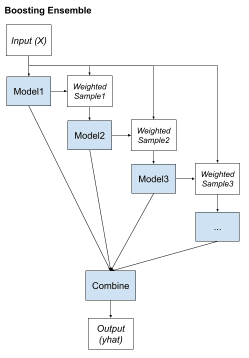
<br>
To summarize, many popular ensemble algorithms are based on this approach, including:

> AdaBoost (canonical boosting) <br>
> Gradient Boosting Machines <br>
> [Stochastic Gradient Boosting (XGBoost and LightGBM)](#cell-3) <font color='lightgreen' size="1">Which has been used</font>

## <font color='orange'>Dependencies</font>

In [ ]:
!unzip "/content/drive/MyDrive/computational intelligence course/dataset.zip" -d "/content/drive/MyDrive/computational intelligence course/dataset/"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron

path_dataset = '/content/drive/MyDrive/computational intelligence course/dataset/'

## <font color='orange'>Load Dataset</font>

In [ ]:
def read_features(path):
   '''
   Returns the list of features of a face that are read from a text file
   Parameters:
       path (str): path of feature_file.txt
   '''
   try:
     f = open(path, 'r')
     lines = f.readlines()
     f.close()
   except OSError:
     print("Could not open/read file:", path)
     return

   features = []
   for line in lines:
     line = line.replace('[[', '').replace(']]', '').strip()
     feature = list(map(lambda a : float(a), line.split()))
     features.extend(feature)
   return features


def create_df(path):
  '''
   Returns test/train data frame that contains numerical features of face_1 and face_2,
   and subtraction of these numerical features,
   and label that indicates whether these two faces belong to one person or not
   Parameters:
       path (str): path of pairsDevTrain.txt/pairsDevTest.txt
  '''
  try:
      f = open(path, 'r')
      lines = f.readlines()
      f.close()
  except OSError:
      print("Could not open/read file:", path)
      return

  x1 = []
  x2 = []
  labels = []
  n = int(lines[0])
  for i in range(1, n+1):
    line = lines[i]
    parts = line.split()
    path1 = path_dataset + "lfw/" + parts[0] + "/" + parts[0] + "_" + str(parts[1]).zfill(4) + ".txt"
    path2 = path_dataset + "lfw/" + parts[0] + "/" + parts[0] + "_" + str(parts[2]).zfill(4) + ".txt"
    x1.append(read_features(path1))
    x2.append(read_features(path2))
    labels.append(True)

  for i in range(n+1, 2*n+1):
    line = lines[i]
    parts = line.split()
    path1 = path_dataset + "lfw/" + parts[0] + "/" + parts[0] + "_" + str(parts[1]).zfill(4) + ".txt"
    path2 = path_dataset + "lfw/" + parts[2] + "/" + parts[2] + "_" + str(parts[3]).zfill(4) + ".txt"
    x1.append(read_features(path1))
    x2.append(read_features(path2))
    labels.append(False)

  x1 = np.array(x1)
  x2 = np.array(x2)
  sub = x1 - x2
  df = pd.DataFrame(columns= ['x1', 'x2', 'subtraction', 'label'])
  df.x1 = x1.tolist()
  df.x2 = x2.tolist()
  df.subtraction = sub.tolist()
  df.label = labels
  return df

In [ ]:
train_df = create_df(path_dataset + "pairsDevTrain.txt")
test_df = create_df(path_dataset + "pairsDevTest.txt")

In [ ]:
train_df.to_parquet(path_dataset + "trainset.parquet", index=False)
test_df.to_parquet(path_dataset + "testset.parquet", index=False)

## <font color='orange'>Preprocess & Extract Distance Features</font>

In [ ]:
train_df = pd.read_parquet(path_dataset + "trainset.parquet")
test_df = pd.read_parquet(path_dataset + "testset.parquet")

In [ ]:
stdScaler = StandardScaler()
def normalize(df):
  df['x1'] = stdScaler.fit_transform(df['x1'].tolist()).tolist()
  df['x2'] = stdScaler.fit_transform(df['x2'].tolist()).tolist()
  df['subtraction'] = stdScaler.fit_transform(df['subtraction'].tolist()).tolist()
  return df

  
train_df = normalize(train_df)
test_df = normalize(test_df)

In [ ]:
# def do_pca(df, n=3):
#   pca = PCA(n_components=n)
#   df['x1'] = pca.fit_transform(df['x1'].tolist()).tolist()
#   df['x2'] = pca.fit_transform(df['x2'].tolist()).tolist()
#   return df

# train_df = do_pca(train_df)
# test_df = do_pca(test_df)

We use these 3 distance measures as features:
<br>

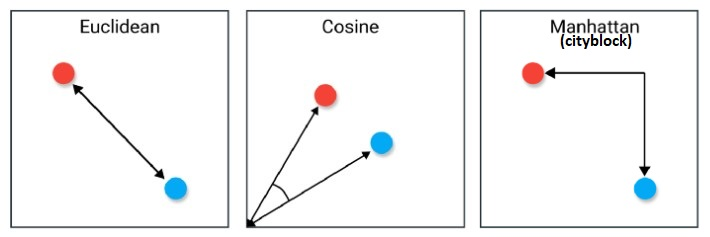

In [ ]:
def distances(df):
  df['cosine'] = df.apply(lambda y: distance.cosine(y.x1, y.x2), axis=1)
  df['euclidean'] = df.apply(lambda y: distance.euclidean(y.x1, y.x2), axis=1)
  # df['chebyshev'] = df.apply(lambda y: distance.chebyshev(y.x1, y.x2), axis=1)
  df['cityblock'] = df.apply(lambda y: distance.chebyshev(y.x1, y.x2), axis=1) # Manhattan
  # df['correlation'] = df.apply(lambda y: distance.correlation(y.x1, y.x2), axis=1)
  return df.drop(columns=["x1","x2"])

train_df = distances(train_df)  
test_df = distances(test_df)

In [ ]:
train_df.head()

,subtraction,label,cosine,euclidean,cityblock
0,"[0.23113322050990426, -0.6081501268499538, -0....",True,0.409722,20.284064,4.417184
1,"[-0.12479491978918901, 0.8076019103984892, -1....",True,0.776713,22.981348,3.610012
2,"[-1.4008537813465272, -0.567947699300059, -0.4...",True,0.629385,27.788242,5.730646
3,"[0.19247477237824986, 0.4713947405770958, -0.3...",True,0.419443,20.141570,3.559685
4,"[0.1473503343898001, 1.4034431743345863, -1.92...",True,0.625576,25.493352,5.074279


In [ ]:
# def sub_cal(df):
#   df["subtraction"] = (np.array(df["x1"].to_list()) - np.array(df["x2"].to_list())).tolist()
#   return df

# train_df = sub_cal(train_df)
# test_df = sub_cal(test_df)

In [ ]:
# train_df = pd.concat([train_df, pd.DataFrame(train_df["subtraction"].to_list()).add_prefix("sub_")], axis=1)
# test_df = pd.concat([test_df, pd.DataFrame(test_df["subtraction"].to_list()).add_prefix("sub_")], axis=1)

In [ ]:
# train_df = pd.concat([train_df, pd.DataFrame(train_df["x1"].to_list()).add_prefix("x1_")], axis=1)
# train_df = pd.concat([train_df, pd.DataFrame(train_df["x2"].to_list()).add_prefix("x2_")], axis=1)
# test_df = pd.concat([test_df, pd.DataFrame(test_df["x2"].to_list()).add_prefix("x2_")], axis=1)
# test_df = pd.concat([test_df, pd.DataFrame(test_df["x1"].to_list()).add_prefix("x1_")], axis=1)

In [ ]:
# train_df = train_df.drop(columns=["x1","x2"])
# test_df = test_df.drop(columns=["x1","x2"])

In [ ]:
# convert True -> 1 and False -> 0
train_df["label"] = train_df["label"].astype(int)
test_df["label"] = test_df["label"].astype(int)

features = train_df.drop(columns=["label","subtraction"]).columns.tolist()

x_train = train_df.drop(columns=["label","subtraction"])
y_train = train_df["label"]
x_test = test_df.drop(columns=["label","subtraction"])
y_test = test_df["label"]

<a name="cell-3"></a>
## <font color='orange'>LightGBM</font>
**LightGBM** is a gradient boosting framework that uses tree based learning algorithms.

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train, feature_name=features)
lgb_test = lgb.Dataset(x_test, y_test, feature_name = features)

In [ ]:
params = {
'task': 'train'
, 'boosting_type': 'gbdt'
, 'objective': 'multiclass'
, 'num_class': 2
, 'metric': 'multi_logloss'
}
 
gbm = lgb.train(params, lgb_train, num_boost_round=250, early_stopping_rounds = 15, valid_sets=[lgb_test])

[1]	valid_0's multi_logloss: 0.628054
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's multi_logloss: 0.574348
[3]	valid_0's multi_logloss: 0.530532
[4]	valid_0's multi_logloss: 0.493546
[5]	valid_0's multi_logloss: 0.462177
[6]	valid_0's multi_logloss: 0.435419
[7]	valid_0's multi_logloss: 0.41299
[8]	valid_0's multi_logloss: 0.392709
[9]	valid_0's multi_logloss: 0.375311
[10]	valid_0's multi_logloss: 0.360729
[11]	valid_0's multi_logloss: 0.348065
[12]	valid_0's multi_logloss: 0.337075
[13]	valid_0's multi_logloss: 0.327184
[14]	valid_0's multi_logloss: 0.318852
[15]	valid_0's multi_logloss: 0.311178
[16]	valid_0's multi_logloss: 0.304562
[17]	valid_0's multi_logloss: 0.298741
[18]	valid_0's multi_logloss: 0.293579
[19]	valid_0's multi_logloss: 0.288805
[20]	valid_0's multi_logloss: 0.284591
[21]	valid_0's multi_logloss: 0.281561
[22]	valid_0's multi_logloss: 0.279437
[23]	valid_0's multi_logloss: 0.277126
[24]	valid_0's multi_logloss: 0.275355
[25]	valid_0

In [ ]:
predictions = gbm.predict(x_test)
 
y_pred = []
for prediction in predictions:
  prediction_class = np.argmax(prediction)
  y_pred.append(prediction_class)

accuracy = accuracy_score(y_pred, y_test)
print("accuracy: {:.1f}%".format(accuracy * 100))

accuracy: 89.4%


<a name="cell-1"></a>
## <font color='orange'>Random Forest</font>
In random forests, each tree in the ensemble is built from a sample drawn with replacement from the training set. 
<br>
Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size `max_features`.

In [ ]:
steps = [('scaler', StandardScaler()), ('RF', RandomForestClassifier())]
pipeline = Pipeline(steps) # define Pipeline object

parameters = {'RF__n_estimators':[40, 60, 80, 100, 120],
              'RF__criterion':["gini", "entropy"],
              'RF__max_depth':[2, 3], # weak learner
              # 'RF__max_features': [2, 3, 4, 5]
              }
              
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [ ]:
grid.fit(x_train, y_train)
print("score = ", grid.score(x_train, y_train)) 
print("best parameters from train data: ", grid.best_params_)

score =  0.8868181818181818
best parameters from train data:  {'RF__criterion': 'gini', 'RF__max_depth': 2, 'RF__n_estimators': 100}


In [ ]:
y_pred = grid.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)
print("accuracy: {:.1f}%".format(accuracy * 100))

accuracy: 89.4%


<a name="cell-2"></a>
## <font color='orange'>Stacked Model</font>
Stacked generalization is a method for combining estimators to reduce their biases. More precisely, the predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. This final estimator is trained through cross-validation.

We use 9 base estimators which will be stacked together: 
*   3 Perceptron
*   3 SVC
*   3 Decision tree

In [ ]:
percep1 = Perceptron(tol=1e-3, max_iter=200)
percep2 = Perceptron(tol=1e-3, max_iter=200)
percep3 = Perceptron(tol=1e-3, max_iter=200)

svm1 = SVC(kernel='poly', degree=1)
svm2 = SVC(kernel='poly', degree=2)
svm3 = SVC(kernel='poly', degree=3)

dTree1 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dTree2 = DecisionTreeClassifier(criterion='gini', max_depth=3)
dTree3 = DecisionTreeClassifier(criterion='gini', max_depth=4)

In this section, we select the best final estimator using grid search

In [ ]:
estimators = [
     ('p1', percep1), ('p2', percep2), ('p3', percep3),
     ('svm1', svm1), ('svm2', svm2), ('svm3', svm3),
     ('dt1', dTree1), ('dt2', dTree2), ('dt33', dTree3)
]

steps = [('scaler', StandardScaler()), ('SC', StackingClassifier(estimators=estimators))]
pipeline = Pipeline(steps) # define Pipeline object

parameters = {'SC__final_estimator':[SVC(), Perceptron(), DecisionTreeClassifier()]}

grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [ ]:
grid.fit(x_train, y_train)
print("score = ", grid.score(x_train, y_train)) 
print("best parameters from train data: ", grid.best_params_)

score =  0.8881818181818182
best parameters from train data:  {'SC__final_estimator': SVC()}


In [ ]:
y_pred = grid.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)
print("accuracy: {:.1f}%".format(accuracy * 100))

accuracy: 89.0%


## <font color='orange'>Conclusion</font>


> <font color='black'>**LightGBM** <font color='lightgreen'> 89.4%</font><br>
> <font color='black'>**Random Forest** </font> <font color='lightgreen'> 89.4%</font><br>
> <font color='black'>**Stacked Model** <font> <font color='lightgreen'> 89.0%</font><br>

